## Video Preprocessing
Getting frames from the input video

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import matplotlib.animation as animation
import natsort
import maxflow
%matplotlib inline

In [2]:
video = "./original_data/night2.mov"
capture = cv2.VideoCapture(video)

In [3]:
frame_num = 0
actual_count = 0
fps = capture.get(cv2.CAP_PROP_FPS)
print("FPS = %d" % fps)

def rescale_frame(frame, percent = 60):
    width = int(frame.shape[1] * percent / 100)
    height = int(frame.shape[0] * percent / 100)
    dim = (width, height)
    return cv2.resize(frame, dim, interpolation=cv2.INTER_AREA)

while (True):
    suc, frame = capture.read()
    if frame_num %2 != 0:
        # skip this frame
        frame_num += 1
        continue
    if suc:
        rescale_f = rescale_frame(frame)
        cv2.imwrite("./data_frame/frame_{}.jpg".format(actual_count), rescale_f)
        actual_count += 1
        frame_num += 1
    else:
        break
capture.release()

FPS = 30


## Video segmentation with MRF

In [45]:
folder = "./data_frame/night2/"

In [46]:
def get_all_frames(folder):
    frames = []
    gray_frames = []
    file_paths = natsort.natsorted(os.listdir(folder), alg=natsort.ns.PATH | natsort.ns.IGNORECASE)
    
    for file in file_paths:
        gray_frames.append(cv2.imread(os.path.join(folder, file), 0))
        frames.append(cv2.imread(os.path.join(folder, file)))
    
    return frames, gray_frames

In [47]:
frames, gray_frames = get_all_frames(folder)

### Heuristically set background/foreground points

In [7]:
def get_fg_bg_points(image):
    height = image.shape[0]
    width = image.shape[1]
    
    bg = (int(1/10 * height), int(1/2 * width))
    fg = (int(1/2 * height), int(1/2 * width))
    return bg, fg

### MRF: Using code from HW3

In [8]:
def min_max_scale(img):
    if img.max() == img.min():
        return (img - img.min()) / (img.max() - img.min() + 1e-2)
    return (img - img.min()) / (img.max() - img.min())


def segment(img, obj, bg, lambda_=1):
    g = maxflow.Graph[float]()
    h, w = img.shape[:2]
    nodeids = g.add_grid_nodes((h, w))
    
    def dist_in_color(a, b):
        # from: https://en.wikipedia.org/wiki/Color_difference
        # which basically is an Euclidean distance
        return np.linalg.norm(a - b)

    w_hori = np.zeros((h, w))
    w_vert = np.zeros((h, w))

    # Calculate the weights for the horizontal neighborhood
    for i in range(0, h):
        for j in range(1, w):
            w_hori[i, j] = dist_in_color(img[i, j], img[i, j-1])

    # Calculate the weights for the vertical neighborhood 
    for i in range(1, h):
        for j in range(0, w):
            w_vert[i, j] = dist_in_color(img[i, j], img[i-1, j])

    # --- Build neighbor links ---
    hori_struc=np.array([[0, 0, 0],
                                [1, 0, 0], 
                                [0, 0, 0]])
    vert_struc=np.array([[0, 1, 0],
                                [0, 0, 0],
                                [0, 0, 0]])
    g.add_grid_edges(nodeids, w_hori, structure=hori_struc, symmetric=True)
    g.add_grid_edges(nodeids, w_vert, structure=vert_struc, symmetric=True)
    
    # --- Build st edges ---
    obj_color = img[int(obj[0]), int(obj[1])]
    bg_color = img[int(bg[0]), int(bg[1])]
    obj_color_mat = np.tile(obj_color, (h, w, 1)) # replicate object's color for matrix subtraction
    bg_color_mat = np.tile(bg_color, (h, w, 1))
    
    obj_weights = np.zeros(img.shape[:2]) # weights to be added to the graph (for st edges)
    bg_weights = np.zeros(img.shape[:2])
    
    obj_weights += np.linalg.norm(img - obj_color_mat, axis=2) * lambda_
    bg_weights += np.linalg.norm(img - bg_color_mat, axis=2) * lambda_
    
    # add st edges to the graph
    g.add_grid_tedges(nodeids, obj_weights, bg_weights)
    
    # find the max flow
    g.maxflow()
    
    # return segmentation result
    sgm = g.get_grid_segments(nodeids)
    return sgm

In [9]:
# Select foreground and background points
bg, fg = get_fg_bg_points(frames[0])

### Show example segmenting result

In [10]:
def get_segment(frame, bg, fg, gaussian_sigma=(5,5), lambda_=0.5, blur=True, denoise=True):
    if blur:
        blur_frame = cv2.GaussianBlur(frame, gaussian_sigma, cv2.BORDER_DEFAULT)
        sgm = segment(blur_frame, bg, fg, lambda_=lambda_)
    else:
        sgm = segment(frame, bg, fg, lambda_=lambda_)
        
    sgm_img = np.array(sgm, dtype="uint8") * 255
    kernel = np.ones((3, 3), np.uint8)
    if denoise:
        sgm_img = cv2.dilate(sgm_img, kernel, iterations=1)
        sgm_img = cv2.erode(sgm_img, kernel, iterations=1)
    contours, _ = cv2.findContours(sgm_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(sgm_img, contours, -1, (0, 255, 0), 2)
    return sgm_img

In [11]:
example = frames[410]
example = cv2.cvtColor(example, cv2.COLOR_BGR2RGB)

# Get segment result
sgm_example_no_blur = get_segment(example, bg, fg, lambda_=0.5, blur=False, denoise=False)
sgm_example_33 = get_segment(example, bg, fg, gaussian_sigma=(3, 3), lambda_=0.5, denoise=False)
sgm_example_55 = get_segment(example, bg, fg, gaussian_sigma=(5, 5), lambda_=0.5, denoise=False)

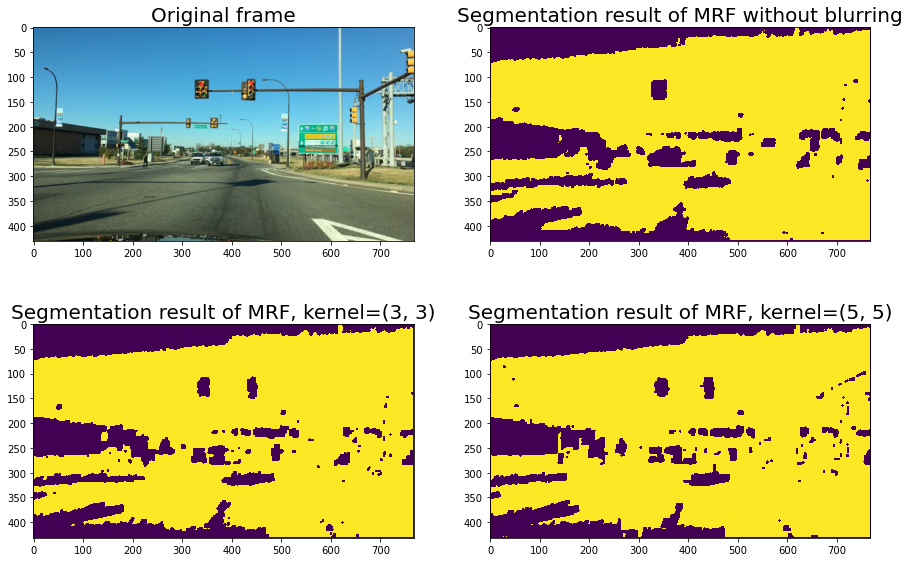

In [12]:
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
ax[0][0].imshow(example)
ax[0][0].set_title("Original frame", size=20)
ax[0][1].imshow(sgm_example_no_blur, interpolation='none')
ax[0][1].set_title("Segmentation result of MRF without blurring", size=20)
ax[1][0].imshow(sgm_example_33, interpolation='none')
ax[1][0].set_title("Segmentation result of MRF, kernel=(3, 3)", size=20)
ax[1][1].imshow(sgm_example_55, interpolation='none')
ax[1][1].set_title("Segmentation result of MRF, kernel=(5, 5)", size=20)
plt.show()

In [13]:
example = frames[410]
example = cv2.cvtColor(example, cv2.COLOR_BGR2RGB)

# Get segment result with and without post-processing
sgm_example_wo_post_processing = get_segment(example, bg, fg, gaussian_sigma=(5, 5), lambda_=0.5, denoise=False)
sgm_example_w_post_processing = get_segment(example, bg, fg, gaussian_sigma=(5, 5), lambda_=0.5, denoise=True)

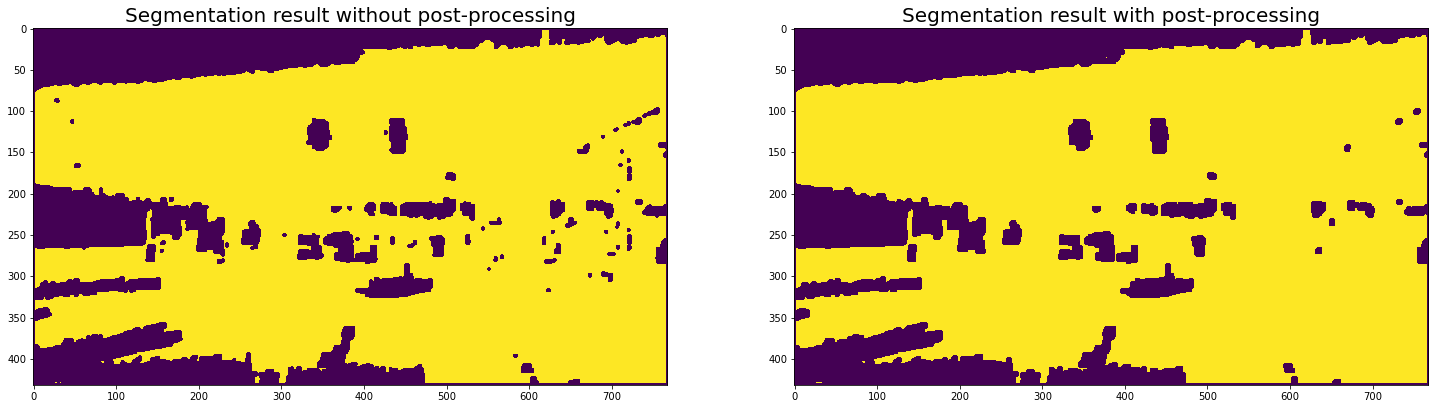

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(25, 10))
ax[0].imshow(sgm_example_wo_post_processing, interpolation='none')
ax[0].set_title("Segmentation result without post-processing", size=20)
ax[1].imshow(sgm_example_w_post_processing, interpolation='none')
ax[1].set_title("Segmentation result with post-processing", size=20)
plt.show()

In [29]:
def example_result(frame, sgm, th=True):
    contours, _ = cv2.findContours(sgm, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    frame_res = frame.copy()
    if th:
        contour_areas = [cv2.contourArea(c) for c in contours]
        max_contour = max(contour_areas)
        for i, cnt in enumerate(contours):
            if contour_areas[i] > 100 and contour_areas[i] < max_contour:
                cv2.drawContours(frame_res, [cnt], 0, (0, 255, 0), 2)
    else:
        cv2.drawContours(frame_res, contours, -1, (0, 255, 0), 2)
    return frame_res

In [30]:
without_thresholding = example_result(example, sgm_example_w_post_processing, th=False)
with_thresholding = example_result(example, sgm_example_w_post_processing, th=True)

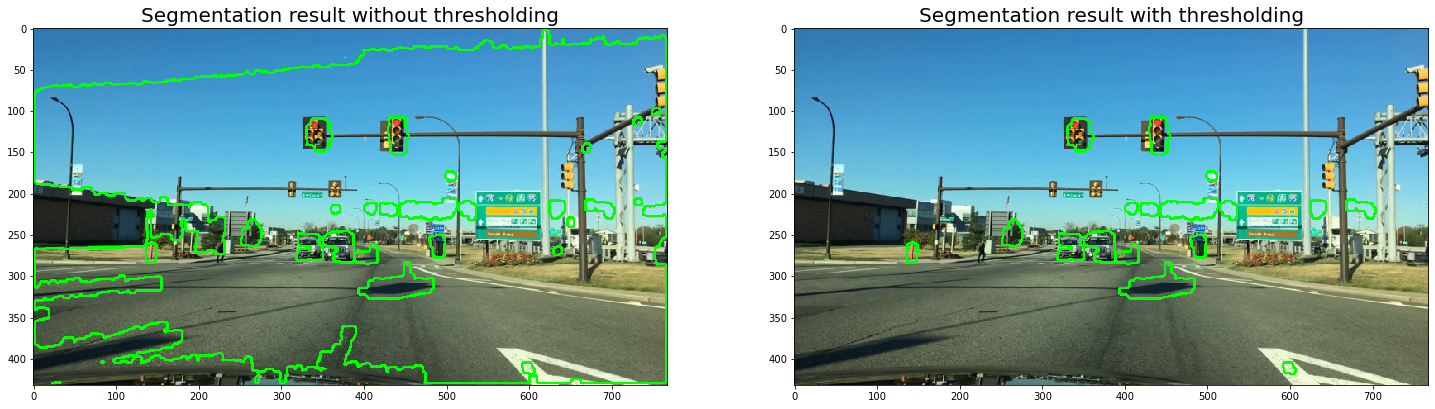

In [31]:
fig, ax = plt.subplots(1, 2, figsize=(25, 10))
ax[0].imshow(without_thresholding, interpolation='none')
ax[0].set_title("Segmentation result without thresholding", size=20)
ax[1].imshow(with_thresholding, interpolation='none')
ax[1].set_title("Segmentation result with thresholding", size=20)
plt.show()

An example execution time

In [18]:
%%time
example = frames[410]
example = cv2.cvtColor(example, cv2.COLOR_BGR2RGB)

# Get segment result with and without post-processing
ex_time = get_segment(example, bg, fg, lambda_=0.5)

CPU times: total: 2.83 s
Wall time: 2.82 s


## Video segmentation
Processing all frames

In [21]:
def segment_all_frames(frame_list, bg, fg, lambda_):
    seg_result = []
    
    for frame in frame_list:
        # Blur current frame
        sgm = get_segment(frame, bg, fg, lambda_=lambda_)
        # Save sgm to result list
        seg_result.append(sgm)
        
    return seg_result

In [22]:
%%time
seg_list = segment_all_frames(frames, bg, fg, 0.5)

CPU times: total: 28min 56s
Wall time: 28min 57s


In [23]:
def frame_draw_contour(frame_list, sgm_list):
    result = []
    for i, frame in enumerate(frame_list):
        curr = frame.copy()
        sgm = sgm_list[i]
        contours, _ = cv2.findContours(sgm, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        contour_areas = [cv2.contourArea(c) for c in contours]
        max_contour = max(contour_areas)
        for i, cnt in enumerate(contours):
            if contour_areas[i] > 100 and contour_areas[i] <= 4000 and contour_areas[i] < max_contour:
                cv2.drawContours(curr, [cnt], 0, (0, 255, 0), 2)
        result.append(curr)
    
    return result

In [24]:
def generate_video(frames, video_name):
    height = frames[0].shape[0]
    width = frames[0].shape[1]
    video = cv2.VideoWriter(video_name, 0, 10, (width,height))
    for image in frames:
        video.write(image)
    video.release()

In [25]:
result = frame_draw_contour(frames, seg_list)

### Output the result

In [28]:
generate_video(result, "output.mp4")

### Draw some result frames for the report

In [48]:
sgm_result_list = []
for f in [50, 150, 250, 350, 450, 550]:
    frame = frames[f]
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    sgm = get_segment(frame, bg, fg, gaussian_sigma=(5, 5), lambda_=0.5)
    # Draw contour
    contours, _ = cv2.findContours(sgm, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    frame_res = frame.copy()
    contour_areas = [cv2.contourArea(c) for c in contours]
    max_contour = max(contour_areas)
    for i, cnt in enumerate(contours):
        if contour_areas[i] > 100 and contour_areas[i] <= 4000 and contour_areas[i] < max_contour:
            cv2.drawContours(frame_res, [cnt], 0, (0, 255, 0), 2)
    sgm_result_list.append(frame_res)

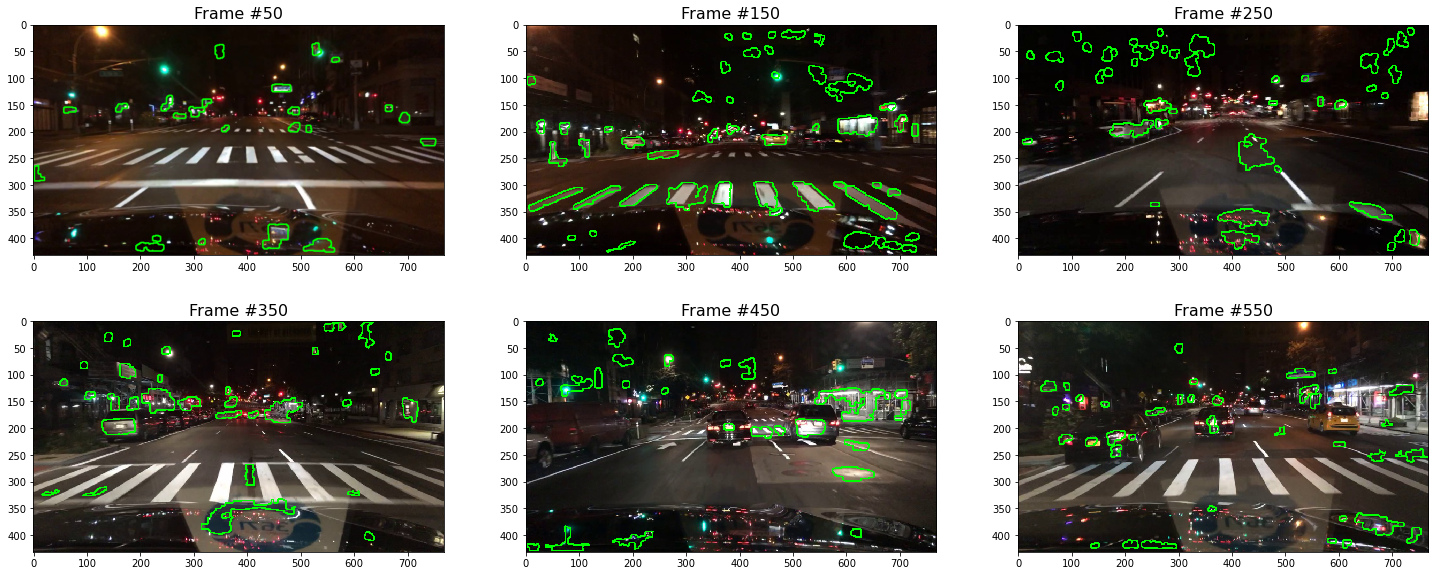

In [49]:
fig, ax = plt.subplots(2, 3, figsize=(25, 10))
ax[0][0].imshow(sgm_result_list[0])
ax[0][0].set_title("Frame #50", size=16)
ax[0][1].imshow(sgm_result_list[1], interpolation='none')
ax[0][1].set_title("Frame #150", size=16)
ax[0][2].imshow(sgm_result_list[2], interpolation='none')
ax[0][2].set_title("Frame #250", size=16)
ax[1][0].imshow(sgm_result_list[3], interpolation='none')
ax[1][0].set_title("Frame #350", size=16)
ax[1][1].imshow(sgm_result_list[4], interpolation='none')
ax[1][1].set_title("Frame #450", size=16)
ax[1][2].imshow(sgm_result_list[5], interpolation='none')
ax[1][2].set_title("Frame #550", size=16)
plt.show()